In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.html.widgets as widgets
from IPython.html.widgets import interactive
from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#Cellular DNF

L'objectif est de calculer les interactions latérales en utilisant un substrat cellulaire et redondant de facons à maximiser le mise à l'échelle et la robustesse.
La fonction latérale effectue une convolution globale de l'activité par un noyau de type différence de Gaussiene symétrique.
L'activité est relatrivement éparse. Le noyau Gaussien à une composante positive et négative de sorte qu'il soit possible de réduire le probleme à la simulation d'une seule convolution avec un noyau Gaussien.




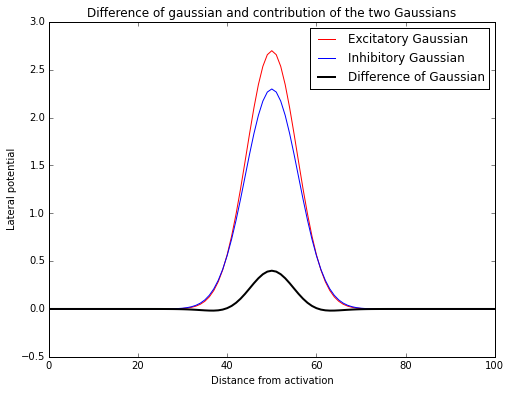

In [4]:
def gaussian(x0,sigma):
    x = np.arange(size)
    return np.exp(-np.power((x - x0)/(2.*sigma), 2.))
    
def getDog(iExc,iInh,sigmaExc,sigmaInh):
    gExc = gaussian(size//2,sigmaExc)*iExc
    gInh = gaussian(size//2,sigmaInh)*iInh
    return gExc-gInh,gExc,gInh

size = 101


def plotDOG(iExc,iInh,sigmaExc,sigmaInh):
    x = np.arange(size)
    dog,gExc,gInh = getDog(iExc,iInh,sigmaExc,sigmaInh)
    plt.plot(x,gExc,label='Excitatory Gaussian',color='red')
    plt.plot(x,gInh,label='Inhibitory Gaussian',color='blue')
    plt.plot(x,gExc-gInh,label='Difference of Gaussian',color='black',lw=2)
    plt.legend()
    plt.xlabel("Distance from activation")
    plt.ylabel("Lateral potential")
    plt.title("Difference of gaussian and contribution of the two Gaussians")
    

slider_ie = widgets.FloatSliderWidget(min=0.0, max=10, step=0.1, value=4.7)
slider_ii = widgets.FloatSliderWidget(min=0.0, max=10, step=0.1, value=1.7)
slider_se = widgets.FloatSliderWidget(min=0.0, max=10, step=0.1, value=3.5)
slider_si = widgets.FloatSliderWidget(min=0.0, max=10, step=0.1, value=10)
w=widgets.interactive(plotDOG,iExc=slider_ie,iInh=slider_ii,sigmaExc=slider_se,sigmaInh=slider_si)
display(w)

On calcule les interactions latérales avec une convolution entre l'activité ci-dessous et le noyaux ci-dessus.

In [5]:

def getActivation1D(act):
    activation = np.zeros((size))
    activation[(size*np.asarray(act)).astype(np.int)] = 1
    return activation

def plotActivation(act1,act2):
    act = [act1,act2]
    plt.plot(x,getActivation1D(act))
    
slider_act1 = widgets.FloatSliderWidget(min=0.0,max=1.0,step=0.01,value=3/8)
slider_act2 = widgets.FloatSliderWidget(min=0.0,max=1.0,step=0.01,value=5/8)
w=widgets.interactive(plotActivation,act1=slider_act1,act2=slider_act2)
display(w)


NameError: name 'x' is not defined

Le résultat de cette convolution ets le suivant :

In [6]:
import scipy.ndimage.filters as filter
def getLateral(activation,weight):
    return  filter.convolve(activation,weight)


ImportError: No module named 'scipy'

In [7]:

def plotConvolution(act1,act2):
    x = np.arange(size)
    act = [act1,act2]
    activation = getActivation1D(act)
    weight,exc,inh = getDog(4.7,1.7,3.5,10)
    lat = getLateral(activation,weight)
    convExc = getLateral(activation,exc)
    convInh = getLateral(activation,inh)
    
    plt.plot(x,convExc,label='Exc. Gaussian',color='red')
    plt.plot(x,convInh,label='Inh. Gaussian',color='blue')
    plt.plot(x,lat,label='Diff. of Gaussian',color='black',lw=2)
   
    plt.hlines(0,0,size-1)
    plt.legend()
    plt.xlabel("Distance from activation")
    plt.ylabel("Lateral potential")
    plt.title("Difference of gaussian and contribution of the two Gaussians")
    
slider_act1 = widgets.FloatSliderWidget(min=0.0,max=1.0,step=0.01,value=3/8)
slider_act2 = widgets.FloatSliderWidget(min=0.0,max=1.0,step=0.01,value=5/8)

w=widgets.interactive(plotConvolution,act1=slider_act1,act2=slider_act2)
                      
display(w)

NameError: name 'getLateral' is not defined

On voit donc que la condition essentielle pour maintenir le comportement est que l'inhibition se propage sur une très longue distance et ce, malgrès les autres sources d'inhibition.

Une condition encore plus forte est la superposition des gaussiennes : si l'on rapproche beaucoup les deux activité, il faut que leur gaussiennes respectives s'additiones.
L'addition des deux gaussienes excitatrices aura un maximum à 8, alors que les deux gaussiennes séparément ont un maximum à 5.

## Automate basé sur la règle de propagation de feu
Proposé par Nazim Fates

In [8]:
def max4(a,b,c,d):
    """
    Element-wise maximum betwen 4 arrays
    """
    ab = np.maximum(a,b)
    cd = np.maximum(c,d)
    return np.maximum(ab,cd)


def update(X,maxState=100,pTrans=1.):
    """
    Update following the fire  propagation rule
    Online transformation of X
    """
    #Neighbors value
    N = X[:-2,1:-1];S = X[2:,1:-1];E = X[1:-1,2:];W = X[1:-1,:-2]
    maximum = max4(N,S,E,W)
    
    #Current state
    x = X[1:-1,1:-1]
    
    diff = maximum - x
    rand = np.random.random(x.shape) < pTrans
    
    transmission = (x != maxState) & (diff > 0) & rand
    evaporation = (x != maxState)  & (~transmission)
    
    x[transmission] = x[transmission] + diff[transmission]/2
    x[evaporation] = (x[evaporation].astype(np.float)/1.5).astype(np.int)

In [9]:
size = 101
maxState = 200
pTrans = 0.93
timeEnd = 400 #number of iteration
shape = (size,size)

def getActivation2D(act):
    activation = np.zeros(shape)
    actPos = (size*np.asarray(act)).astype(np.int)
    activation[actPos,actPos] = 1
    return activation

In [10]:
xRep = [] #stack each result of experiment
nbRep = 10 #number of repetition of the experiment
actPos = [3/8,5/8] #initial activity on the diagonal
activation = getActivation2D(actPos)

for rep in range(nbRep):
    X = activation * maxState
    for i in range(timeEnd):
        update(X,maxState,pTrans)
    xRep.append(X)

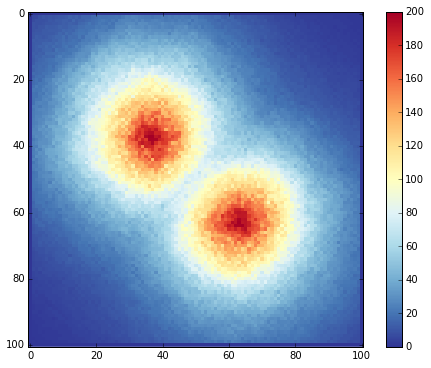

In [11]:
#average the experiments results
XX = np.array(xRep)
mean = np.mean(XX,axis=0)
#plot them
plt.imshow(mean,interpolation='None',cmap='RdYlBu_r')
plt.colorbar()

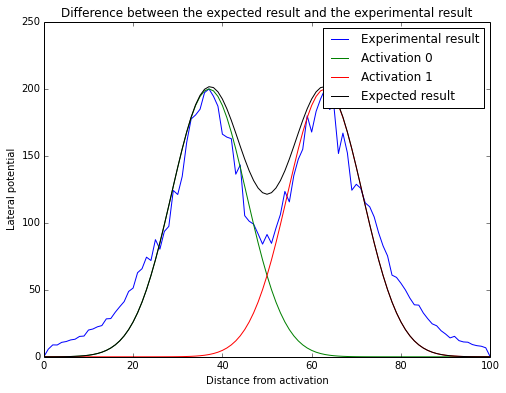

In [67]:
def plotActivite(act,sigmaFact=5):  
    gauss = []
    indexAct = np.where(act==1)[0].T#index of activation==1
    for x0 in indexAct:
        gauss.append(gaussian(x0,pTrans*sigmaFact)*maxState)
    
    for g,i in zip(gauss,range(len(gauss))):
        plt.plot(g,label='Activation '+str(i))
        
    plt.plot(np.sum(gauss,axis=0),label='Expected result',color='black')
    plt.legend()
    plt.xlabel("Distance from activation")
    plt.ylabel("Lateral potential")
    plt.title("Difference between the expected result and the experimental result")

def plotInteractif(sigmaFact):
    plt.plot(np.diag(mean),label='Experimental result')
    plotActivite(np.diag(activation),sigmaFact)



slider = widgets.FloatSliderWidget(min=0.0, max=10, step=0.1, value=6.4)
w=widgets.interactive(plotInteractif,sigmaFact=slider)
display(w)

On voit ici que l'additivité n'est pas respectée. Il y a un écart entre le profil théorique ne noir et la courbe obtenue en bleu.